# Step 1: Import Libraries and Start MATLAB Engine

In [1]:
import csv
import statistics
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim


import subprocess

import matlab.engine
import logging
import os

# Initialize logging
logging.basicConfig(level=logging.INFO)

def start_matlab_engine():
    try:
        eng = matlab.engine.start_matlab()
        matlab_version = eng.eval('version')
        logging.info("MATLAB Engine started successfully.")
        logging.info(f"MATLAB Version: {matlab_version}")
        return eng
    except Exception as e:
        logging.error("Failed to start MATLAB Engine.")
        logging.error(f"Error: {e}")
        return None

# Start the MATLAB engine
eng = start_matlab_engine()

INFO:root:MATLAB Engine started successfully.
INFO:root:MATLAB Version: 23.2.0.2459199 (R2023b) Update 5


# Step 2: Run Initial Setup Scripts in MATLAB

In [2]:
# # Run addWecSimSource.m to set up WEC-Sim
# print("> Step 1: Running addWecSimSource.m...")
# print("####################################################################################")
# eng.run('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/addWecSimSource.m', nargout=0)
# print("> Step 1 executed successfully!")
# print("     ")

# # Run bemio.m to process hydrodynamic data
# print("> Step 2: Running bemio.m...")
# print("####################################################################################")
# eng.run('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/hydroData/bemio.m', nargout=0)
# print("> Step 2 executed successfully!")
# print("     ")
def run_matlab_script(engine, script_path):
    try:
        engine.run(script_path, nargout=0)
        logging.info(f"Successfully executed {script_path}")
    except Exception as e:
        logging.error(f"Failed to run {script_path}")
        logging.error(f"Error: {e}")

# Assuming 'eng' is the MATLAB engine instance from Block 1
# Replace these with variables or configurations
wec_sim_script = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/addWecSimSource.m'
bemio_script = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/hydroData/bemio.m'

logging.info("> Running WEC-Sim setup script...")
run_matlab_script(eng, wec_sim_script)

logging.info("> Running BEMIO script for hydrodynamic data processing...")
run_matlab_script(eng, bemio_script)

INFO:root:> Running WEC-Sim setup script...
INFO:root:Successfully executed /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/addWecSimSource.m
INFO:root:> Running BEMIO script for hydrodynamic data processing...
INFO:root:Successfully executed /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/hydroData/bemio.m


# Step 3: Define The Template And Output File Paths 

In [3]:
# # Define the paths for the template and output MATLAB script files
# template_path = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/wecSimInputFile.TEMPLATE.m'
# output_path = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/wecSimInputFile.m'


def set_file_paths(base_path, template_file, output_file):
    template_path = os.path.join(base_path, template_file)
    output_path = os.path.join(base_path, output_file)

    if not os.path.exists(template_path):
        logging.error(f"Template file not found: {template_path}")
        return None, None

    return template_path, output_path

# Configure your base path and file names
base_path = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/'
template_file = 'wecSimInputFile.TEMPLATE.m'
output_file = 'wecSimInputFile.m'

template_path, output_path = set_file_paths(base_path, template_file, output_file)

if template_path and output_path:
    logging.info("Template and output file paths set successfully.")

INFO:root:Template and output file paths set successfully.


# Step 4: Define Simulation Parameters

In [4]:
# # Simulation parameters that stay constant
# time_start = 0
# time_end = 600
# dt = 0.1

# # # Define a range of PTO damping values to test
# # pto_damping_values = np.linspace(1100000, 1300000, num=21)  # Define a range for exploration
# # wave_heights_values = np.linspace(6, 10, num=11)
# # wave_periods_values = np.linspace(1, 4, num=11)

# pto_damping_values = np.linspace(1000000, 2000000, num=30)  # Define a range for exploration
# wave_heights_values = np.linspace(20, 40, num=20)
# wave_periods_values = np.linspace(10, 40, num=20)

# pto_stiffness = 0


# Load parameters from a configuration file or environment variables
# For demonstration, we'll use hardcoded values
time_start = 0
time_end = 600
dt = 0.1

# Parameter ranges for PTO damping, wave heights, and periods
pto_damping_range = (1000000, 2000000)
wave_heights_range = (20, 40)
wave_periods_range = (10, 40)

# Validate ranges
if pto_damping_range[0] >= pto_damping_range[1]:
    logging.error("Invalid PTO damping range.")
    # Handle error or exit

# Generate parameter values
pto_damping_values = np.linspace(*pto_damping_range, num=30)
wave_heights_values = np.linspace(*wave_heights_range, num=20)
wave_periods_values = np.linspace(*wave_periods_range, num=20)

pto_stiffness = 0  # Set PTO stiffness, add rationale if needed

logging.info("Simulation parameters set successfully.")

INFO:root:Simulation parameters set successfully.


# Step 5: Run Simulations For Each PTO Damping Value

In [5]:
# # Define the Epsilon-Greedy parameters
# # Epsilon decay parameters
# epsilon = 0.9 # Starting exploration rate 0.3
# epsilon_min = 0.1  # Minimum exploration rate 0.01
# num_episodes = 20  # Total number of episodes to run
# decay_interval = 200  # Apply decay every 'decay_interval' episodes
# decay_factor = 0.75  # Decay factor to apply

# epsilon_start=epsilon
# epsilon_end=epsilon_min

# Function to dynamically adjust epsilon
def adjust_epsilon(epsilon, epsilon_min, decay_factor, performance_metric=None):
    # Example: Adjust decay factor based on some performance metric
    if performance_metric and performance_metric < some_threshold:
        decay_factor *= adjustment_rate
    new_epsilon = max(epsilon * decay_factor, epsilon_min)
    return new_epsilon

# Load ε-greedy parameters from a configuration file or set them here
epsilon = 0.9  # Starting exploration rate
epsilon_min = 0.1  # Minimum exploration rate
decay_factor = 0.98  # Decay factor

num_episodes = 1600  # Total number of episodes
batch_size = 40     # Define batch size
num_batches = num_episodes // batch_size

decay_interval = 20  # Apply decay every 'decay_interval' episodes

# Optimization parameters
learning_rate = 0.009
weight_decay = 0.001

# Validate parameters
if epsilon < epsilon_min or epsilon > 1:
    logging.error("Invalid epsilon values.")
    # Handle error or exit

# Use the function to adjust epsilon dynamically (example usage, actual implementation may vary)
for episode in range(num_episodes):
    if episode % decay_interval == 0:
        epsilon = adjust_epsilon(epsilon, epsilon_min, decay_factor)
        logging.info(f"Epsilon adjusted to {epsilon} at episode {episode}")

epsilon_start = epsilon
epsilon_end = epsilon_min

INFO:root:Epsilon adjusted to 0.882 at episode 0
INFO:root:Epsilon adjusted to 0.86436 at episode 20
INFO:root:Epsilon adjusted to 0.8470728 at episode 40
INFO:root:Epsilon adjusted to 0.830131344 at episode 60
INFO:root:Epsilon adjusted to 0.81352871712 at episode 80
INFO:root:Epsilon adjusted to 0.7972581427776 at episode 100
INFO:root:Epsilon adjusted to 0.781312979922048 at episode 120
INFO:root:Epsilon adjusted to 0.765686720323607 at episode 140
INFO:root:Epsilon adjusted to 0.7503729859171349 at episode 160
INFO:root:Epsilon adjusted to 0.7353655261987921 at episode 180
INFO:root:Epsilon adjusted to 0.7206582156748162 at episode 200
INFO:root:Epsilon adjusted to 0.7062450513613199 at episode 220
INFO:root:Epsilon adjusted to 0.6921201503340935 at episode 240
INFO:root:Epsilon adjusted to 0.6782777473274115 at episode 260
INFO:root:Epsilon adjusted to 0.6647121923808633 at episode 280
INFO:root:Epsilon adjusted to 0.6514179485332461 at episode 300
INFO:root:Epsilon adjusted to 0.

## 5a: Define A Neural Network

In [6]:
# # Define a simple neural network
# class SimpleNet(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(SimpleNet, self).__init__()
#         self.fc = nn.Linear(input_size, output_size)

#     def forward(self, x):
#         return self.fc(x)

In [7]:
# class SimpleNet(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)  # First layer
#         self.relu = nn.ReLU()                 # Non-linear activation function
#         self.fc2 = nn.Linear(64, 32)          # Second layer
#         self.fc3 = nn.Linear(32, output_size) # Output layer

#     def forward(self, x):
#         x = self.relu(self.fc1(x))  # Apply ReLU after first layer
#         x = self.relu(self.fc2(x))  # Apply ReLU after second layer
#         return self.fc3(x)          # Output layer

In [8]:
# class SimpleNet(nn.Module):
#     def __init__(self, input_size, output_size):
#         super(SimpleNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, 64)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, output_size)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)  # Apply dropout after ReLU activation
#         x = self.relu(self.fc2(x))
#         return self.fc3(x)

In [9]:
class SimpleNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)  # Dropout layer with 20% dropout rate
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after ReLU activation
        x = self.relu(self.fc2(x))
        return self.fc3(x)

## 5b. Initialize the network and optimizer

In [10]:
from torch.optim.optimizer import Optimizer, required

class SAGA(Optimizer):
    def __init__(self, params, lr=0.01):
        defaults = dict(lr=lr)
        super(SAGA, self).__init__(params, defaults)
        # Initialize gradient table
        for group in self.param_groups:
            for p in group['params']:
                state = self.state[p]
                state['gradient_table'] = torch.zeros_like(p.data)
                state['average_gradient'] = torch.zeros_like(p.data)

    def step(self, closure=None):
        """
        Performs a single optimization step (parameter update).
        
        Args:
            closure (callable, optional): A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]
                
                # SAGA update
                p.data -= group['lr'] * (grad - state['gradient_table'] + state['average_gradient'])
                
                # Update gradient table and average gradient
                state['average_gradient'] -= state['gradient_table'] / p.data.numel()
                state['gradient_table'].copy_(grad)
                state['average_gradient'] += grad / p.data.numel()

        return loss

In [11]:
input_size = 2  # For wave frequency and amplitude
output_size = 3  # For the three actions: increase, decrease, keep the same
net = SimpleNet(input_size, output_size)
# optimizer = optim.RAdam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = optim.Rprop(net.parameters(), lr=learning_rate)
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.LBFGS(net.parameters(), lr=learning_rate, history_size=batch_size)

# optimizer=SAGA(net.parameters(), lr=0.01)

# Scheduler to adapt the learning rate
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

## 5c. Function to calculate reward (placeholder, define your own)

### 5ci: Total Power

In [12]:
def calculate_reward(float_velocity, spar_velocity, pto_damping, waves_height, waves_period, all_rewards):
    # Convert MATLAB data to Python lists
    float_velocity = [float(x[0]) for x in float_velocity]
    float_velocity = np.array(float_velocity)
    spar_velocity = [float(x[0]) for x in spar_velocity]
    spar_velocity = np.array(spar_velocity)
    
    # print("Shapes:", float_velocity.shape, spar_velocity.shape)
    
    relative_velocity=float_velocity-spar_velocity
    pto_power=pto_damping*np.square(relative_velocity)
    
    wave_power=((1000*pow(9.8068, 2))/(64*np.pi))*pow(waves_height, 2)*waves_period
    
    power=np.sum(np.abs(wave_power-pto_power))
    
    # Add raw power reward to list
    all_rewards.append(power)

    # Calculate running mean and standard deviation of rewards
    mean_reward = np.mean(all_rewards)
    std_reward = np.std(all_rewards) if np.std(all_rewards) > 0 else 1

    # Normalize the reward
    normalized_reward = (power - mean_reward) / std_reward

    return np.abs(normalized_reward)

### 5cii: Efficency

In [13]:
# def calculate_reward(float_velocity, spar_velocity, pto_damping, waves_height, waves_period, all_rewards):
#     # Convert MATLAB data to Python lists
#     float_velocity = np.array([float(x[0]) for x in float_velocity])
#     spar_velocity = np.array([float(x[0]) for x in spar_velocity])
    
#     # Calculate relative velocity
#     relative_velocity = float_velocity - spar_velocity

#     # Calculate PTO power based on damping and relative velocity
#     pto_power = pto_damping * np.square(relative_velocity)

#     # Calculate available wave power
#     wave_power = ((1000 * 9.80665**2) / (64 * np.pi)) * np.square(waves_height) * waves_period

#     # Calculate the efficiency - ratio of PTO power to wave power
#     # Add a small constant to avoid division by zero
#     efficiency = np.sum(pto_power) / (np.sum(wave_power) + 1e-6)

#     # Reward is based on how close the PTO power is to the wave power
#     # Adjust this formula as needed to fit the physical characteristics of your system
#     reward = efficiency
    
#     return reward

### 5ciii: Efficency (2)

In [14]:
# def calculate_reward(float_velocity, spar_velocity, pto_damping, waves_height, waves_period, all_rewards):
#     # Convert MATLAB data to Python lists
#     float_velocity = np.array([float(x[0]) for x in float_velocity])
#     spar_velocity = np.array([float(x[0]) for x in spar_velocity])
    
#     # Calculate relative velocity
#     relative_velocity = float_velocity - spar_velocity

#     # Calculate PTO power based on damping and relative velocity
#     pto_power = pto_damping * np.square(relative_velocity)

#     # Calculate available wave power
#     wave_power = ((1000 * 9.80665**2) / (64 * np.pi)) * np.square(waves_height) * waves_period

#     # Ensure wave_power is never zero to avoid division by zero
#     wave_power = np.maximum(wave_power, 1e-6)

#     # Efficiency is the ratio of PTO power to the available wave power
#     # Clip the efficiency to a max of 1 to ensure it is bounded
#     efficiency = np.minimum(1, pto_power / wave_power)

#     # Reward is the sum or average of efficiency over time
#     # Summing up the efficiencies for simplicity; you may choose to average instead
#     reward = np.sum(efficiency)
    
#     return reward

## 5d. Function to simulate the environment (placeholder)

In [15]:
def simulate_environment(pto_damping, wave_height, wave_period):
    # This function should simulate the environment with the given parameters
    # and return the state and reward (you'll replace this with your actual simulation code)
    state = np.array([wave_height, wave_period])
    reward = np.random.rand(1)  # Random reward as an example
    return state, reward

## 5e. Initialize the lists for storing training data

In [16]:
episode_data = []
epsilon_values = []
all_rewards = []  # Keep all rewards for calculating running mean and std
training_losses = []  # To store loss values for plotting
validation_losses = []

## 5f. Training

In [17]:
# # Initialize the estimated rewards and counts for each PTO damping value
# estimated_rewards = {damping: 0 for damping in pto_damping_values}
# counts = {damping: 0 for damping in pto_damping_values}
# episode_data=[]

# def save_batch_results(batch_num, episodes_data, training_losses, validation_losses, file_path):
#     # Open the file in append mode
#     with open(file_path, 'a', newline='') as file:
#         writer = csv.writer(file)
        
#         # Check if the file is empty to write headers
#         if file.tell() == 0:
#             writer.writerow(["Batch", "Episode", "PTO Damping", "Reward", "Training Loss", "Validation Loss"])
        
#         # Write data for each episode in the batch
#         for i, episode_data in enumerate(episodes_data):
#             # Extract episode-specific data
#             episode_num, pto_damping, reward = episode_data
#             train_loss = training_losses[i]
#             val_loss = validation_losses[i]

#             # Write the row to the CSV file
#             writer.writerow([batch_num, episode_num, pto_damping, reward, train_loss, val_loss])

# for batch in range(num_batches):
#     print(f"Starting batch {batch + 1}/{num_batches}")

#     for episode in range(batch * batch_size, (batch + 1) * batch_size):
#         # Epsilon-Greedy action selection
#         if random.random() < epsilon:
#             # Exploration: choose a random PTO damping value
#             chosen_pto_damping = random.choice(pto_damping_values)
#             waves_height = random.choice(wave_heights_values)
#             waves_period = random.choice(wave_periods_values)
#         else:
#             # Exploitation: choose the PTO damping value with the highest estimated reward
#             chosen_pto_damping = max(estimated_rewards, key=estimated_rewards.get)
        
#         # Use sed to update the wecSimInputFile with the current PTO damping value
#         command = (
#             f"sed 's/WAVES_HEIGHT/{waves_height}/g' '{template_path}' | "
#             f"sed 's/WAVES_PERIOD/{waves_period}/g' | "
#             f"sed 's/PTO_STIFFNESS/{pto_stiffness}/g' | "
#             f"sed 's/TIME_START/{time_start}/g' | "
#             f"sed 's/TIME_END/{time_end}/g' | "
#             f"sed 's/DT/{dt}/g' | "
#             f"sed 's/PTO_DAMPING/{chosen_pto_damping}/g' > '{output_path}'"
#         )
#         subprocess.run(command, shell=True, check=True)

#         # Run the simulation in MATLAB
#         eng.cd('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/', nargout=0)
#         eng.eval('wecSim', nargout=0)
        
#         # Extract simulation results (velocity) and calculate the reward
#         float_velocity = eng.eval("output.bodies(1).velocity", nargout=1)
#         spar_velocity = eng.eval("output.bodies(2).velocity", nargout=1)
#         reward = calculate_reward(
#             float_velocity, spar_velocity, chosen_pto_damping,
#             waves_height, waves_period, all_rewards
#         )

#         # Convert to tensors for neural network training
#         state_tensor = torch.tensor([waves_height, waves_period], dtype=torch.float32).unsqueeze(0)
#         validation_state = torch.tensor([waves_height, waves_period], dtype=torch.float32).unsqueeze(0)
        
#         reward_tensor = torch.tensor([reward], dtype=torch.float32).unsqueeze(0)
#         validation_target = torch.tensor([reward], dtype=torch.float32).unsqueeze(0)
        

#         # Train the neural network
#         optimizer.zero_grad()
#         predicted_reward = net(state_tensor)
#         loss = nn.MSELoss()(predicted_reward, reward_tensor)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0) 
#         optimizer.step()

#         # Record the loss and reward
#         training_losses.append(loss.item())
#         all_rewards.append(reward)
        
#         # Validation loss
#         with torch.no_grad():
#             validation_output = net(validation_state)
#             validation_loss = nn.MSELoss()(validation_output, validation_target)
#             validation_losses.append(validation_loss.item())

#         # Update the estimated rewards and counts for the chosen PTO damping value
#         counts[chosen_pto_damping] += 1
#         old_reward = estimated_rewards.get(chosen_pto_damping, 0)
#         estimated_rewards[chosen_pto_damping] = ((old_reward * (counts[chosen_pto_damping] - 1)) + reward) / counts[chosen_pto_damping]

#         # Epsilon decay
#         if (episode + 1) % decay_interval == 0:
#             epsilon = max(epsilon * decay_factor, epsilon_min)
#         epsilon_values.append(epsilon)
        
#         # Update the learning rate scheduler
#         scheduler.step()
        
#         # Append episode data
#         episode_data.append((episode, chosen_pto_damping, reward))

#     # Optional: Save intermediate results after each batch
#     save_batch_results(batch, episode_data, training_losses, validation_losses, "training_results_MOMENTUM(0.9).csv")

#     # Clear data for the next batch
#     episode_data.clear()
#     training_losses.clear()
#     validation_losses.clear()

In [19]:
## THIS IS FOR USE FOR ONLY L-BFGS ##

def closure():
    optimizer.zero_grad()
    predicted_reward = net(state_tensor)
    loss = nn.MSELoss()(predicted_reward, reward_tensor)
    loss.backward()
    return loss

# Initialize the estimated rewards and counts for each PTO damping value
estimated_rewards = {damping: 0 for damping in pto_damping_values}
counts = {damping: 0 for damping in pto_damping_values}
episode_data=[]

def save_batch_results(batch_num, episodes_data, training_losses, validation_losses, file_path):
    # Open the file in append mode
    with open(file_path, 'a', newline='') as file:
        writer = csv.writer(file)
        
        # Check if the file is empty to write headers
        if file.tell() == 0:
            writer.writerow(["Batch", "Episode", "PTO Damping", "Reward", "Training Loss", "Validation Loss"])
        
        # Write data for each episode in the batch
        for i, episode_data in enumerate(episodes_data):
            # Extract episode-specific data
            episode_num, pto_damping, reward = episode_data
            train_loss = training_losses[i]
            val_loss = validation_losses[i]

            # Write the row to the CSV file
            writer.writerow([batch_num, episode_num, pto_damping, reward, train_loss, val_loss])

for batch in range(num_batches):
    print(f"Starting batch {batch + 1}/{num_batches}")

    for episode in range(batch * batch_size, (batch + 1) * batch_size):
        # Epsilon-Greedy action selection
        if random.random() < epsilon:
            # Exploration: choose a random PTO damping value
            chosen_pto_damping = random.choice(pto_damping_values)
            waves_height = random.choice(wave_heights_values)
            waves_period = random.choice(wave_periods_values)
        else:
            # Exploitation: choose the PTO damping value with the highest estimated reward
            chosen_pto_damping = max(estimated_rewards, key=estimated_rewards.get)
        
        # Use sed to update the wecSimInputFile with the current PTO damping value
        command = (
            f"sed 's/WAVES_HEIGHT/{waves_height}/g' '{template_path}' | "
            f"sed 's/WAVES_PERIOD/{waves_period}/g' | "
            f"sed 's/PTO_STIFFNESS/{pto_stiffness}/g' | "
            f"sed 's/TIME_START/{time_start}/g' | "
            f"sed 's/TIME_END/{time_end}/g' | "
            f"sed 's/DT/{dt}/g' | "
            f"sed 's/PTO_DAMPING/{chosen_pto_damping}/g' > '{output_path}'"
        )
        subprocess.run(command, shell=True, check=True)

        # Run the simulation in MATLAB
        eng.cd('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/', nargout=0)
        eng.eval('wecSim', nargout=0)
        
        # Extract simulation results (velocity) and calculate the reward
        float_velocity = eng.eval("output.bodies(1).velocity", nargout=1)
        spar_velocity = eng.eval("output.bodies(2).velocity", nargout=1)
        reward = calculate_reward(
            float_velocity, spar_velocity, chosen_pto_damping,
            waves_height, waves_period, all_rewards
        )

        # Convert to tensors for neural network training
        state_tensor = torch.tensor([waves_height, waves_period], dtype=torch.float32).unsqueeze(0)
        validation_state = torch.tensor([waves_height, waves_period], dtype=torch.float32).unsqueeze(0)
        
        reward_tensor = torch.tensor([reward], dtype=torch.float32).unsqueeze(0)
        validation_target = torch.tensor([reward], dtype=torch.float32).unsqueeze(0)
        

        # Train the neural network
        optimizer.zero_grad()
        predicted_reward = net(state_tensor)
        loss = nn.MSELoss()(predicted_reward, reward_tensor)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0) 
        optimizer.step(closure)

        # Record the loss and reward
        training_losses.append(loss.item())
        all_rewards.append(reward)
        
        # Validation loss
        with torch.no_grad():
            validation_output = net(validation_state)
            validation_loss = nn.MSELoss()(validation_output, validation_target)
            validation_losses.append(validation_loss.item())

        # Update the estimated rewards and counts for the chosen PTO damping value
        counts[chosen_pto_damping] += 1
        old_reward = estimated_rewards.get(chosen_pto_damping, 0)
        estimated_rewards[chosen_pto_damping] = ((old_reward * (counts[chosen_pto_damping] - 1)) + reward) / counts[chosen_pto_damping]

        # Epsilon decay
        if (episode + 1) % decay_interval == 0:
            epsilon = max(epsilon * decay_factor, epsilon_min)
        epsilon_values.append(epsilon)
        
        # Update the learning rate scheduler
        scheduler.step()
        
        # Append episode data
        episode_data.append((episode, chosen_pto_damping, reward))

    # Optional: Save intermediate results after each batch
    save_batch_results(batch, episode_data, training_losses, validation_losses, "training_results_LBFGS.csv")

    # Clear data for the next batch
    episode_data.clear()
    training_losses.clear()
    validation_losses.clear()

Starting batch 1/40
WEC-Sim: An open-source code for simulating wave energy converters
Version: 5.0.1

Initializing the Simulation Class...
	Case Dir: /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3 

WEC-Sim Input From Standard wecSimInputFile.m Of Case Directory... 
WEC-Sim: An open-source code for simulating wave energy converters
Version: 5.0.1

Initializing the Simulation Class...
	Case Dir: /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3 
Elapsed time is 6.218337 seconds.

WEC-Sim Pre-processing ...   
	Infinite water depth specified in BEM and "waves.waterDepth" not specified in input file.
Set water depth to 200m for visualization.
Elapsed time is 0.282051 seconds.

WEC-Sim Simulation Settings:
	Start Time                     (sec) = 0
	End Time                       (sec) = 600
	Time Step Size                 (sec) = 0.1
	Ramp Function Time             (sec) = 100
	 Number of Time Steps     = 6000 

Wave Environment: 
	Wave Type           

/Users/khalidalnahyan/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


WEC-Sim: An open-source code for simulating wave energy converters
Version: 5.0.1

Initializing the Simulation Class...
	Case Dir: /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3 

WEC-Sim Input From Standard wecSimInputFile.m Of Case Directory... 
WEC-Sim: An open-source code for simulating wave energy converters
Version: 5.0.1

Initializing the Simulation Class...
	Case Dir: /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3 
Elapsed time is 0.912200 seconds.

WEC-Sim Pre-processing ...   
	Infinite water depth specified in BEM and "waves.waterDepth" not specified in input file.
Set water depth to 200m for visualization.
Elapsed time is 0.236672 seconds.

WEC-Sim Simulation Settings:
	Start Time                     (sec) = 0
	End Time                       (sec) = 600
	Time Step Size                 (sec) = 0.1
	Ramp Function Time             (sec) = 100
	 Number of Time Steps     = 6000 

Wave Environment: 
	Wave Type                            = R

# Step 6: Analyze Results And Select Best Damping Value

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


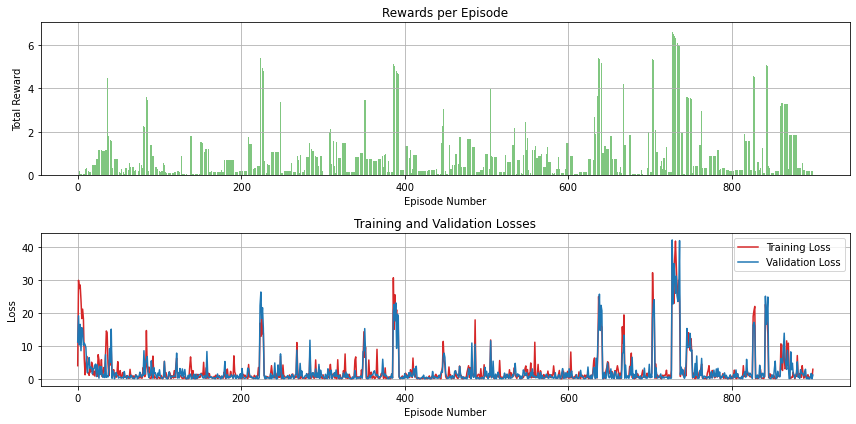

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the data from the file
file_path = 'training_results.csv'
data = pd.read_csv(file_path)

# Extracting data for plotting
episodes = data['Episode']
rewards = data['Reward']
training_losses = data['Training Loss']
validation_losses = data['Validation Loss']

# Plotting Rewards and Epsilon Decay
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.bar(episodes, rewards, color='tab:green', alpha=0.6)
plt.xlabel('Episode Number')
plt.ylabel('Total Reward')
plt.title('Rewards per Episode')
plt.grid(True)

# Plotting Training and Validation Losses
plt.subplot(2, 1, 2)
plt.plot(training_losses, label='Training Loss', color='tab:red')
plt.plot(validation_losses, label='Validation Loss', color='tab:blue')
plt.xlabel('Episode Number')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Step 7: Testing

In [ ]:
num_tests = 100  # Number of random tests to perform

# Lists to store test results
test_heights = []
test_periods = []
test_actions = []

for _ in range(num_tests):
    test_height = random.uniform(*height_range)
    test_period = random.uniform(*period_range)
    test_state = torch.tensor([[test_height, test_period]])

    with torch.no_grad():
        test_output = net(test_state)
        predicted_action = torch.argmax(test_output).item()
    
    # Store the results
    test_heights.append(test_height)
    test_periods.append(test_period)
    test_actions.append(predicted_action)

    # Map the action to a decision
    action_mapping = ["Increase", "Decrease", "Keep the Same"]
    decision = action_mapping[predicted_action]
    print(f"> Test State: Height={test_height:.2f}, Period={test_period:.2f}, Recommended Action: {decision}")

In [ ]:
# Define colors for each action
colors = ['red' if action == 0 else 'green' if action == 1 else 'blue' for action in test_actions]

# Plotting
plt.figure(figsize=(10, 6))
for height, period, color in zip(test_heights, test_periods, colors):
    plt.scatter(height, period, color=color)

plt.xlabel('Wave Height')
plt.ylabel('Wave Period')
plt.title(f'Random Test States and Recommended Actions after {num_tests} Tests')
plt.grid(True)

# Creating a legend manually
plt.scatter([], [], color='red', label='Increase')
plt.scatter([], [], color='green', label='Decrease')
plt.scatter([], [], color='blue', label='Keep the Same')
plt.legend()

plt.show()

# Step 8: Clean Up

In [20]:
# Close the MATLAB engine when done
eng.quit()